In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import os
import pandas as pd
import shap
from urllib2 import urlopen
from zipfile import ZipFile
import numpy as np

/Users/matt.castillon/anaconda/lib/python2.7/site-packages/scikit_learn-0.18.2-py2.7-macosx-10.9-x86_64.egg/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
states = []
nums = range(1, 57)
exclude = [3, 7, 14, 43, 52]
ids = [n for n in nums if n not in exclude]

In [3]:
for i in ids:
    p = str(i).zfill(2)
    url = urlopen('https://htaindex.cnt.org/download/download.php?focus=blkgrp&geoid={0}'.format(p))
    output = open('zipFile.zip', 'wb')
    output.write(url.read())
    output.close()
    data = pd.read_csv('zipFile.zip')
    states.append(data)

In [4]:
all_states = pd.concat(states).reset_index(drop=True)
all_states = all_states[~all_states.isnull().any(axis=1)]

In [5]:
all_states['co2_per_capita'] = all_states['co2_per_hh_local']*all_states['households']/all_states['population']
all_states['population_per_household'] = all_states['population'] / all_states['households']
all_states = all_states[~all_states.isnull().any(axis=1)].reset_index(drop=True)

In [9]:
all_states.sort_values('co2_per_capita')[['cbsa','hh_gravity', 'frac_sfd', 'co2_per_capita']]

,cbsa,hh_gravity,frac_sfd,co2_per_capita
86729,"""New York-Newark-Jersey City, NY-NJ-PA""",255682.0,0.0,0.000000
86581,"""New York-Newark-Jersey City, NY-NJ-PA""",342710.0,0.0,0.000000
85777,"""New York-Newark-Jersey City, NY-NJ-PA""",327833.0,0.0,0.000000
87208,"""New York-Newark-Jersey City, NY-NJ-PA""",310654.0,0.0,0.000000
86587,"""New York-Newark-Jersey City, NY-NJ-PA""",295336.0,1.0,0.000000
85880,"""New York-Newark-Jersey City, NY-NJ-PA""",319879.0,0.0,0.000000
83272,"""New York-Newark-Jersey City, NY-NJ-PA""",338200.0,0.0,0.000000
85879,"""New York-Newark-Jersey City, NY-NJ-PA""",319908.0,0.0,0.000000
81887,"""New York-Newark-Jersey City, NY-NJ-PA""",316610.0,0.0,0.000000
81886,"""New York-Newark-Jersey City, NY-NJ-PA""",285837.0,0.0,0.000000


In [7]:
params = {
    'num_threads': 8,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 100,
    'max_depth': 66,
    'max_drop': -1,
    'learning_rate': 0.01,
    'feature_fraction': 0.333,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'tree_learner': 'voting',
    'lambda_l1': 1,
    'verbose': 0,
    'max_bin': 256,
    'num_iterations': 1000,
    'top_k': 32
}
train = all_states.drop(['co2_per_hh_local',
                         'co2_per_acre_local',
                         'blkgrp',
                         'blkgrps',
                         'cbsa',
                         'population',
                         'households',
                         'co2_per_capita',
                        'vmt_per_hh_nmi',
                        'vmt_cost_nmi',
                        'vmt_cost_80ami',
                        'vmt_per_hh_ami',
                        'vmt_per_hh_80ami',
                        'vmt_cost_ami']
                         , axis=1)
data = lgb.Dataset(train,
                   all_states['vmt_per_hh_nmi'])

gbm = lgb.train(params,
                data,
                num_boost_round=1000)

/Users/matt.castillon/anaconda/lib/python2.7/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


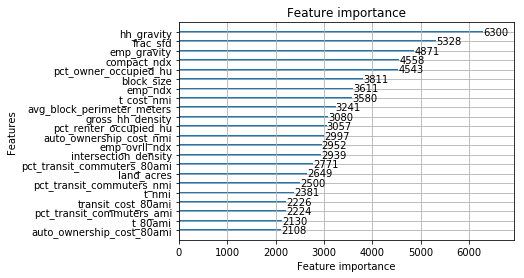

In [8]:
%matplotlib inline
ax = lgb.plot_importance(gbm, max_num_features=22)
plt.show()

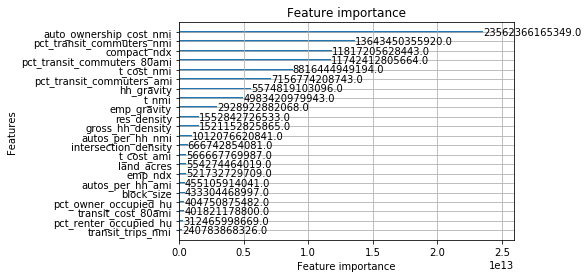

In [10]:
%matplotlib inline
ax = lgb.plot_importance(gbm, max_num_features=22, importance_type='gain')
plt.show()

In [20]:
z = pd.DataFrame()
z['split'] = gbm.feature_importance()
z['gain'] = gbm.feature_importance(importance_type='gain')
z['importance'] = z['split']*z['gain']
z['name'] = train.columns.values
z.sort_values('importance')

,split,gain,importance,name
4,302,1.854713e+09,5.601233e+11,h_ami
5,334,2.323809e+09,7.761523e+11,h_80ami
2,441,4.934643e+09,2.176177e+12,ht_80ami
6,549,5.043846e+09,2.769072e+12,h_nmi
3,718,5.326219e+09,3.824225e+12,ht_nmi
41,669,6.982143e+09,4.671054e+12,median_gross_rent
39,721,8.170415e+09,5.890869e+12,h_cost
1,538,1.159932e+10,6.240433e+12,ht_ami
44,1104,7.309805e+09,8.070025e+12,population_per_household
40,902,1.168144e+10,1.053666e+13,median_smoc


In [16]:
shap_values = shap.TreeExplainer(gbm).shap_values(train)

/Users/matt.castillon/anaconda/lib/python2.7/site-packages/matplotlib-2.0.0-py2.7-macosx-10.9-x86_64.egg/matplotlib/axes/_base.py:1292: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/matt.castillon/anaconda/lib/python2.7/site-packages/matplotlib-2.0.0-py2.7-macosx-10.9-x86_64.egg/matplotlib/axes/_base.py:1297: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


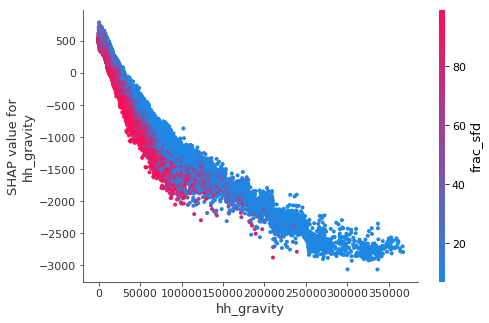

In [19]:
shap.initjs()
shap.dependence_plot('hh_gravity', shap_values, train, interaction_index=33)

In [19]:
train.columns

Index([u'land_acres', u'ht_ami', u'ht_80ami', u'ht_nmi', u'h_ami', u'h_80ami',
       u'h_nmi', u't_ami', u't_80ami', u't_nmi', u'autos_per_hh_ami',
       u'autos_per_hh_80ami', u'autos_per_hh_nmi', u'vmt_per_hh_ami',
       u'vmt_per_hh_80ami', u'vmt_per_hh_nmi', u'pct_transit_commuters_ami',
       u'pct_transit_commuters_80ami', u'pct_transit_commuters_nmi',
       u't_cost_ami', u't_cost_80ami', u't_cost_nmi',
       u'auto_ownership_cost_ami', u'auto_ownership_cost_80ami',
       u'auto_ownership_cost_nmi', u'vmt_cost_ami', u'vmt_cost_80ami',
       u'vmt_cost_nmi', u'transit_cost_ami', u'transit_cost_80ami',
       u'transit_cost_nmi', u'transit_trips_ami', u'transit_trips_80ami',
       u'transit_trips_nmi', u'compact_ndx', u'emp_ovrll_ndx', u'res_density',
       u'gross_hh_density', u'hh_gravity', u'frac_sfd', u'emp_gravity',
       u'emp_ndx', u'block_size', u'intersection_density',
       u'avg_block_perimeter_meters', u'h_cost', u'median_smoc',
       u'median_gross_rent',

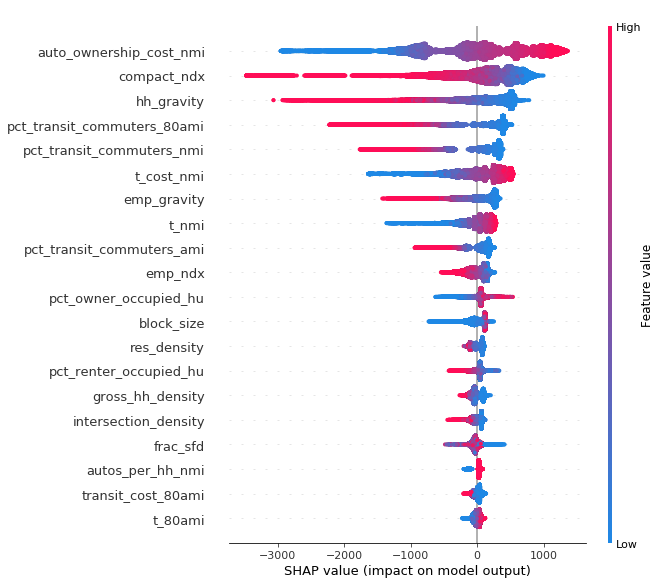

In [20]:
shap.summary_plot(shap_values, train)

In [21]:
explainer = shap.TreeExplainer(gbm)

In [23]:
shap.force_plot(explainer.expected_value, shap_values[0,:], train)

AttributeError: TreeExplainer instance has no attribute 'expected_value'

In [25]:
explainer.

AttributeError: TreeExplainer instance has no __call__ method